 # Libraries Installation

In [ ]:
# Install the necessary libraries as mentioned in file requrirements.txt
!python3 -m pip install --upgrade pip
!pip install -r requirements.txt

# Genetic Algorithm

## Setting up Manual Functions

### Repair Function Setup

In [ ]:
def repair():
    pass

### Objective Function Setup

In [ ]:
def evaluation():
    pass

## Setting up DEAP framework

### Setting up Libraries

In [ ]:
# Necessary Libraries for DEAP and Torch
from deap import base, tools, creator, algorithms

In [ ]:
import random

# --- CONFIGURATION ---
NUM_PUMPS = wn.describe(level=1)['Links']['Pumps']
NUM_TIMESTAMPS = (int(wn.options.time.duration / wn.options.time.hydraulic_timestep) + 1)
CHROM_SIZE = NUM_PUMPS * NUM_TIMESTAMPS  # No of Pumps * No of Timestamps

# --- CREATE TYPES ---

# Assigning Mult-Class Fitness Weigths
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,-1.0,-1.0))

# Defining Individual
creator.create("Individual", list, fitness = creator.FitnessMulti)

toolbox = base.Toolbox()

# --- CREATE TOOLS ---

# Define Binary Genes
toolbox.register("attr_bool", random.randint, 0, 1)

# Define Individual (List of Binary Values)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=CHROM_SIZE)

# Define Random Population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the Fitness function
toolbox.register("evaluate", evaluation)

# Define Selection Methodology
toolbox.register("select", tools.selNSGA3)

# Define Crossover Methodology
toolbox.register("mate", tools.cxTwoPoints)

# Define Mutation Methodology
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.1)

# Set Hall of Fame
hof = tools.HallOfFame(10)

In [ ]:
# --- GENETIC ALGO LOOP---

def run_ga(pop_size = 40, generations = 5, cx_prob = 0.7, mut_prob = 0.4):
    
    population = toolbox.population(n = pop_size)

    # Multi-Objective Statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # Run the Genetic Algorithm
    population, logbook = algorithms.eaMuPlusLambda(population=population,
                                                    toolbox=toolbox,
                                                    mu = round(pop_size * 0.7)
                                                    lambda_= round(pop_size * 0.5),
                                                    cxpb=cx_prob,
                                                    mutpb=mut_prob,
                                                    ngen=generations,
                                                    stats=stats,
                                                    halloffame=hof,
                                                    verbose=True,
                                                    )
    
    best_inds = hof
    print("Best Individual : ", best_inds)
    print("Fitness : ", best_inds.fitness.values)

    return best_inds, logbook, population, hof

best_sols, logbook, population, hof = run_ga()

# Network Simulation testing

In [1]:
import wntr
import numpy as np
from datetime import timedelta

wn = wntr.network.WaterNetworkModel('Network Files/Net3.inp')

In [5]:
# Run a pressure dependent hydraulic simulation
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 50 # m, The required pressure is set to create a scenario where not all demands are met

In [6]:
simulation = wntr.sim.WNTRSimulator(wn)
results = simulation.run_sim()

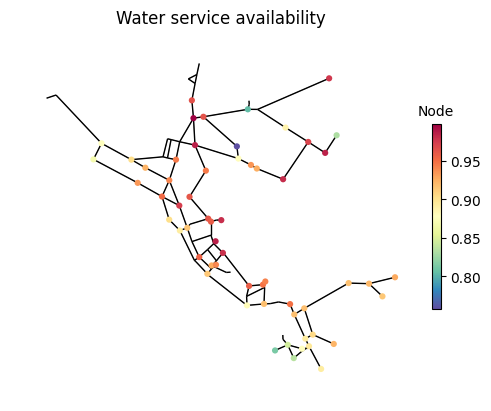

In [7]:
# Compute water service availability, defined as the ratio of delivered demand to the expected demand. 
expected_demand = wntr.metrics.expected_demand(wn)
demand = results.node['demand'].loc[:,wn.junction_name_list]
wsa = wntr.metrics.water_service_availability(expected_demand.sum(axis=0), demand.sum(axis=0))
ax = wntr.graphics.plot_network(wn, node_attribute=wsa, title='Water service availability')

wn.reset_initial_values()

## Auxiliary Functions

In [ ]:
# --- SCHEDULE ADDITION ---

def add_schedule(schedule, wntk):
    for i in range(wntk.describe(level=1)['Links']['Pumps']):
        for j in range(int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1):
            pump = wntk.get_link(wntk.pump_name_list[i])
            condition = wntr.network.controls.SimTimeCondition(wntk, '=', str(timedelta(hours=j)))
            action = wntr.network.controls.ControlAction(pump, 'status', schedule[i][j])
            control = wntr.network.controls.Control(condition, action, name=f'Control_pump{i}_time{j}')
            wntk.add_control(f"Control Pump ID : {i}, Hour : {j}", control)

In [ ]:
# --- ADDED SCHEDULE REMOVAL {EXCLUSIVELY THE ONES FROM ADD SCHEDULE}---

def remove_schedule(wntk):
    for i in range(wntk.describe(level=1)['Links']['Pumps']):
        for j in range(int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1):
            wntk.remove_control(f"Control Pump ID : {i}, Hour : {j}")

In [ ]:
# --- RESHAPE INDIVIDUAL TO SCHEDULE ---

def reshape_individual(individual, wntk):

    # Reshape the individual to a 2D array
    schedule = np.array(individual).reshape(wntk.describe(level=1)['Links']['Pumps'], (int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1)).tolist()

    return schedule

In [ ]:
# --- FEASIBILITY CHECK FUNCTION ---

def check_feasibility(individual, wntk):
    """
    Function to check the feasibility of a given individual.
    """
    pass

In [ ]:
# --- OBJECTIVE CALCULATION FUNCTION ---

def calculate_objective(individual, wntk):
    """
    Function to calculate the objective value for a given individual.
    """
    pass